In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/MyDrive/PROJECTS/vae')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
!unzip /content/gdrive/MyDrive/DATASETS/Celeb_A/celeba-dataset.zip

Archive:  /content/gdrive/MyDrive/DATASETS/Celeb_A/celeba-dataset.zip
replace img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
from experiments.celebA.architecture import build_model
vae = build_model()
vae.load_weights('/content/gdrive/MyDrive/PROJECTS/vae/experiments/celebA/results/checkpoints/0024.tf')


Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet_embedding (Sequenti  (None, 128, 128, 8)       2420      
 al)                                                             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| batch_normalization (Batc  (None, 128, 128, 3)       12       |
| hNormalization)                                               |
|                                                               |
| conv2d (Conv2D)            (None, 128, 128, 8)       2408     |
|                                                               |
| dropout (Dropout)          (None, 128, 128, 8)       0        |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 resnet_block_1 (Functional  (None, 64, 64, 16)        32136     
 )                                                               
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [8]:
# lets verify that the vae works: We simply try to generate a new human face
import tensorflow as tf
z = vae.prior_distribution.sample()
z = z[tf.newaxis, ...] # batchify
decoded = vae.decode(z)

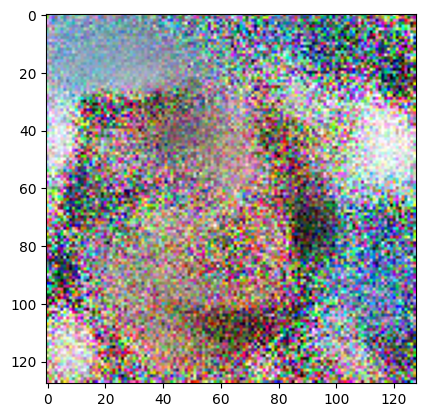

In [9]:
import matplotlib.pyplot as plt
reconstruction = decoded.sample()
reconstruction = reconstruction[0]
plt.imshow(reconstruction)

In [3]:
import tensorflow as tf
import os

DATA_DIR = '/content/img_align_celeba/img_align_celeba'
BATCH_SIZE = 256

def preprocessing(x):
    x = x/255
    return (x,tf.constant([]))

dataset_train, dataset_val  = tf.keras.utils.image_dataset_from_directory(
    directory=DATA_DIR,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=None,
    image_size=(128,128),
    shuffle=True,
    seed=42,
    validation_split = 0.05,
    subset = 'both',)

n_trainingssamples = len(dataset_train)

dataset_train = dataset_train.map(preprocessing).batch(BATCH_SIZE)
dataset_val = dataset_val.map(preprocessing).batch(BATCH_SIZE)

Found 202599 files belonging to 1 classes.
Using 192470 files for training.
Using 10129 files for validation.


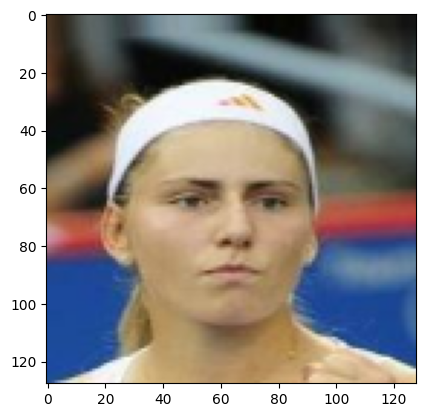

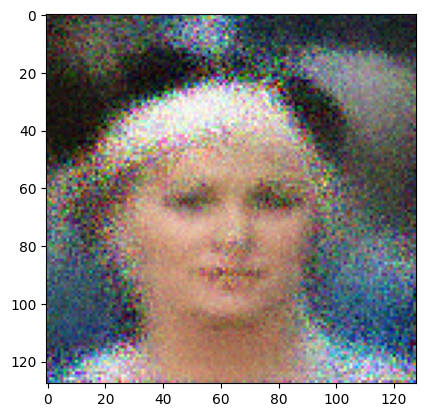

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([ 4.3278086e-01,  2.7080226e-01, -8.5243024e-04, ...,
        5.2047700e-02,  5.2949852e-01,  1.5058613e+00], dtype=float32)>

In [11]:
batch = dataset_val.as_numpy_iterator().next()[0]
elem = batch[0]
plt.imshow(elem)
plt.show()
r = vae(tf.constant([elem]))[0]
plt.imshow(r)
plt.show()

z = vae.get_latent_representation(tf.constant([elem]))[0]
z

In [12]:
import numpy as np
fig, axes = plt.subplots(15,15, figsize=(20, 20))
z = vae.prior_distribution.sample(15*15)
reconstruction = vae.get_reconstruction(z)
for r, ax, in zip(reconstruction, np.ravel(axes)):
    r = np.clip(r, 0, 1)
    ax.imshow(r)
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

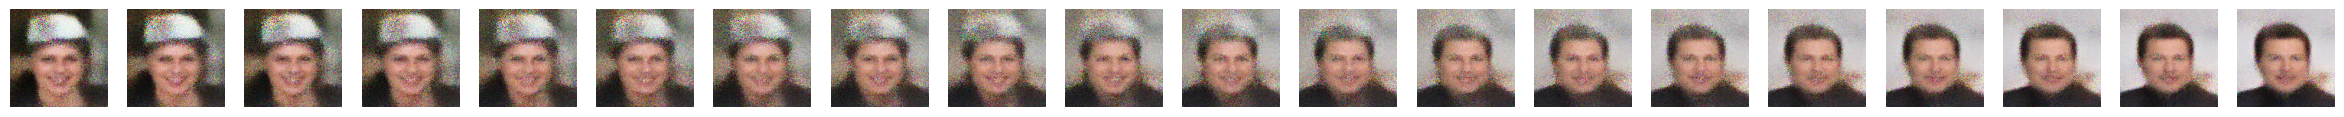

In [24]:
img1 = dataset_val.as_numpy_iterator().next()[0][46]
img2 = dataset_val.as_numpy_iterator().next()[0][46+1]

fig, axes = plt.subplots(1, 20, figsize=(30, 6))

# interpolation in latent space
z1, z2 = vae.get_latent_representation(np.stack([img1, img2]))
interpolation_range = np.linspace(0,1,20)
for ax, fraction in zip(np.ravel(axes), interpolation_range):
    z = z1*(1-fraction) + z2*fraction
    r = vae.get_reconstruction(z[np.newaxis, ...])[0]
    r = np.clip(r, 0, 1)
    ax.imshow(r)
    ax.axis('off')
plt.show()

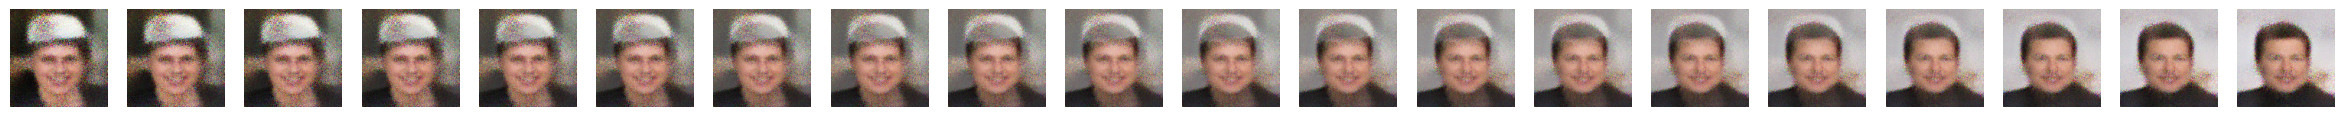

In [13]:
img1 = dataset_val.as_numpy_iterator().next()[0][46]
img2 = dataset_val.as_numpy_iterator().next()[0][46+1]

img1, img2 = vae(np.stack([img1, img2]))

fig, axes = plt.subplots(1, 20, figsize=(30, 6))

# interpolation pixel space
interpolation_range = np.linspace(0,1,20)
for ax, fraction in zip(np.ravel(axes), interpolation_range):
    img = img1*(1-fraction) + img2*fraction
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [7]:
import pandas as pd
df = pd.read_csv('/content/list_attr_celeba.csv')
print(df.shape)
display(df.head())
print(df.columns)

(202599, 41)


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


In [8]:
df_male = df.loc[df['Male']==1]
print(df_male.shape)

(84434, 41)


In [16]:
img = dataset_val.as_numpy_iterator().next()[0][42]

for i in range(3):
    fig, axes = plt.subplots(1, 10, figsize=(30,3))

    ax = axes[0]
    z = vae.get_latent_representation(img[np.newaxis, ...])[0]
    ax.bar(range(len(z)), z, width=1)

    for ax in axes[1:]:
        r = vae.get_reconstruction(z[np.newaxis, ...])[0]
        r = np.clip(r, 0, 1)
        ax.axis('off')
        ax.imshow(r)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.

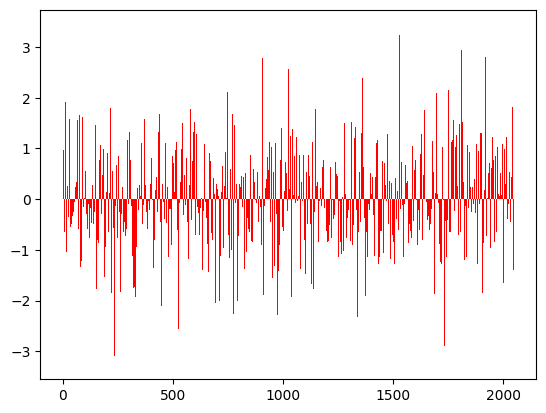

In [76]:
z = vae.prior_distribution.sample()
plt.bar(range(len(z)), z, width=1, color='red')
plt.show()


In [5]:
dataset_train = dataset_train.rebatch(2048)
batch = dataset_train.as_numpy_iterator().next()
latents = vae.get_latent_representation(batch)

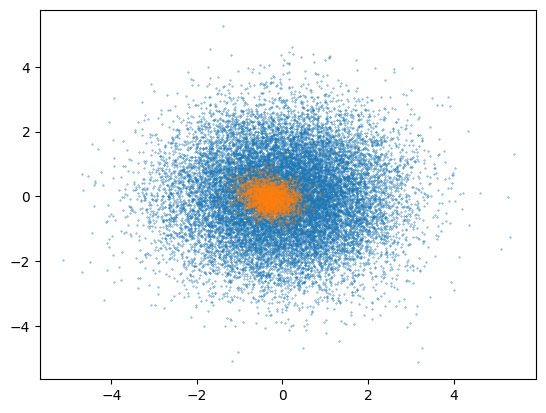

In [6]:
import sklearn.decomposition as decomp
pca = decomp.PCA(n_components=2)

random_latents = vae.prior_distribution.sample(20000)# sample according to prior distribution
components = pca.fit_transform(random_latents)

import matplotlib.pyplot as plt
plt.scatter(components[:,0], components[:,1], s=0.1)

components = pca.transform(latents)
plt.scatter(components[:,0], components[:,1], s=0.1)
plt.show()

In [12]:
import os

# grab a batch of male images
BATCH_SIZE = 1024
DATADIR = '/content/img_align_celeba/img_align_celeba'

for filename in df_male['image_id'].iloc[:BATCH_SIZE]:
    imgs = tf.constant([plt.imread()])

2       000003.jpg
6       000007.jpg
7       000008.jpg
11      000012.jpg
12      000013.jpg
           ...    
2420    002421.jpg
2422    002423.jpg
2425    002426.jpg
2430    002431.jpg
2431    002432.jpg
Name: image_id, Length: 1024, dtype: object